In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import itertools
import random
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

from keras.callbacks import EarlyStopping

from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model


Using TensorFlow backend.


# Task 1a) Define the Function "generatedataset()"
The purpose of this task is to define a function named `generatedataset()`. This function's main objective is to process and generate a dataset from a provided CSV file. It works by loading data from the CSV file, performing some manipulations based on the parameters given, and eventually generating three output structures: a modified DataFrame, a set of training data, and a set of corresponding labels.

The function takes three arguments:
- `file_dir`: The file path of the input CSV file. This is where our raw data is located.
- `sampling_index`: An optional parameter that defines the intervals at which columns will be sampled in our dataset. Its default value is 1, meaning that every column will be included.

The function returns three structures:
- `generated_df`: a dictionary of modified data frames.
- `generated_train_data`: The processed data that can be used for model training.
- `generated_train_label`: The corresponding labels for the training data.


In [ ]:
def generatedataset(file_dir, sampling_index=1):
    """
    Generates a dataset from a given CSV file.

    Args:
        file_dir (str): Path of the CSV file.
        sampling_index (int, optional): Sampling number for columns. Default is 1.

    Returns:
        tuple: A tuple containing three elements:
            - generated_df (pandas Data.DataFrame): A dictionary of modified data frames.
            - generated_train_data (dict or pandas.DataFrame): Generated data (TL=Flase).
            - generated_train_label (dict or pandas.DataFrame): Generated labels.
    """

    # Load the csv data into a DataFrame
    df = pd.read_csv(file_dir)
    # Initialize dictionaries to store generated data, labels and modified data frames
    generated_train_data = []
    generated_train_label = []
    generated_df = []


    # Select all columns starting from the 4th column
    modified_df = df.iloc[:, 3:]
    # Modify column names based on certain conditions
    modified_df.columns = [(float(col[4:])/100) if col.startswith('inat') else ((float(col[5:])/100) if col.startswith('outat') else col) for col in modified_df.columns]
    # Sample columns of Indf every 'sampling_index' interval
    indf = modified_df.iloc[:, 0:84].iloc[:, ::sampling_index]
    # Select the next 84 columns as Oudf
    Oudf = modified_df.iloc[:, 84:168]

    # Store the generated data, labels and modified DataFrame
    generated_train_data= indf
    generated_train_label = Oudf
    generated_df = modified_df

    # Return the generated data, labels and modified DataFrame(s)
    return generated_df, generated_train_data, generated_train_label


# Task 1a') Data Pre-processing: Generating the Dataset and Checking its Dimensions

In this task, we will be involved in the pre-processing of our data. The steps in this phase will include loading a CSV file that contains our raw dataset, generating a processed dataset, and examining the dimensions of our data.

1. **Loading the CSV File**: The dataset is stored in a CSV file named 'Single_EDFA_Dataset.csv'. We begin by loading this file for further operations.

2. **Generating the Dataset**: We will use the `generatedataset()` function defined earlier, which will modify our loaded data according to specific conditions, and return three distinct outputs - a modified DataFrame, generated training data, and corresponding labels.

3. **Checking the Dataset Dimensions**: It's crucial to understand the shape of our data before we proceed to the next stages (like model building or data analysis). So, we will print the dimensions of the modified DataFrame, the generated training data, and labels.

4. **Viewing the Data**: To ensure our data has been processed correctly, we will print the generated training data and labels.

5. **Extracting Channel Information**: Finally, we will extract channel names from the column headers of our DataFrame. These channel names will be converted to wavelengths for further processing or analysis. This is done by selecting specific columns, slicing the column names, and performing a mathematical operation on the sliced strings.

In [ ]:
# Define the directory of the CSV file to be used
file_dir = r'Single_EDFA_Dataset.csv'

# Call the 'generatedataset' function with specified parameters
# This function returns the modified dataframe, generated training data, and corresponding labels
generated_df, generated_train_data, generated_train_label = generatedataset(file_dir, sampling_index=1)

# Check the shape of the dataframe
print("Shape of modified dataframe: ", generated_df.shape)
print("Shape of generated training data: ", generated_train_data.shape)
print("Shape of generated labels: ", generated_train_label.shape)
print('_________________________________________________________________\n')

print("Generated training data: ", generated_train_data)
print('_________________________________________________________________\n')

print("Generated labels: ", generated_train_label)


# Load the CSV file into a DataFrame
df = pd.read_csv('Single_EDFA_Dataset.csv')


# Extract channel names from the first row, convert them to wavelengths
# Here we select the columns from index 3 to 87, extract the part of the column name after 'ch_', convert it to integer and divide by 100
channels = [int(x[4:])/100 for x in df.columns[3:87]]

# Now 'channels' contains the wavelengths corresponding to each channel

Shape of modified dataframe:  (16497, 168)
Shape of generated training data:  (16497, 84)
Shape of generated labels:  (16497, 84)
_________________________________________________________________

Generated training data:         1527.82  1528.29  1528.76  1529.23  1529.70  1530.17  1530.64  1531.11  \
0      -20.262  -19.152  -19.402  -18.902  -19.052  -19.192  -19.172  -19.092   
1      -20.798  -19.688  -20.338  -19.888  -19.898  -19.918  -19.868  -19.838   
2      -21.227  -20.627  -21.417  -20.827  -20.847  -20.797  -20.807  -20.727   
3      -23.007  -22.307  -22.907  -22.247  -22.187  -22.367  -22.217  -22.137   
4      -24.132  -23.302  -23.952  -23.342  -23.122  -23.532  -23.632  -23.752   
...        ...      ...      ...      ...      ...      ...      ...      ...   
16492  -22.505  -22.115  -22.765  -22.235  -22.135  -22.335  -22.125  -22.065   
16493  -23.770  -23.090  -23.690  -23.280  -23.010  -23.670  -23.670  -23.730   
16494  -24.769  -24.109  -24.669  -24.539  -24.5

# Task 1b) Defining a Function for Visualizing Data from a Specific Row of the DataFrame

In this task, our goal is to define a function that can visualize data from a specific row within our DataFrame. This function, `plot_row()`, will help us inspect and understand the distribution of data within individual rows more clearly by displaying the data as a plot.

The `plot_row()` function accepts three parameters:
- `df`: The DataFrame that contains our data.
- `row_index`: The index of the row that we want to visualize.
- `sampling_index`: The intervals at which columns will be sampled from the selected row. This can help us avoid overcrowding in the plot when there are many columns.



In [ ]:
def plot_row(df, row_index, sampling_index):
    # Select the column name for x-axis
    x = df.columns[0]
    y1 = df.iloc[row_index, 0:84][::sampling_index]
    y2 = df.iloc[row_index, 84:168]
    plt.plot(y1, marker='o', label='Input Power')
    plt.plot(y2, marker='o', label='Output Power')
    plt.xlabel('Channel (Wavelength in nm)')
    plt.ylabel('Power (dBm)')
    plt.title('Entry {}'.format(row_index))
    plt.legend()
    plt.grid(True)
    plt.show()

# Task 1b') Demonstrating Plot Generation with an Example and Data Verification

In this task, we aim to utilize the `plot_row()` function that we previously defined to visualize the data in a specific row from our DataFrame. This process will not only confirm the correct operation of our function but also help us to understand the patterns and distribution of data within an individual row.


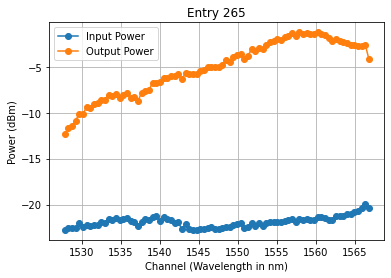

1527.82   -20.262
1528.29   -19.152
1528.76   -19.402
1529.23   -18.902
1529.70   -19.052
            ...  
1564.95    -0.846
1565.42    -0.826
1565.89    -1.136
1566.36    -1.446
1566.83    -2.486
Name: 0, Length: 168, dtype: float64

In [ ]:
# Set the index of the row we want to plot
row_index = 265
# Set the sampling interval. In this case, we're using a value of 1, which means that every column will be included in the plot.
sampling_index = 1

# Call the 'plot_row' function that we defined earlier, passing in our generated DataFrame, the index of the row we want to plot, and the sampling interval.
plot_row(generated_df, row_index, sampling_index)

# Display the data in the row of the DataFrame at the specified index for examination
generated_df.iloc[0]


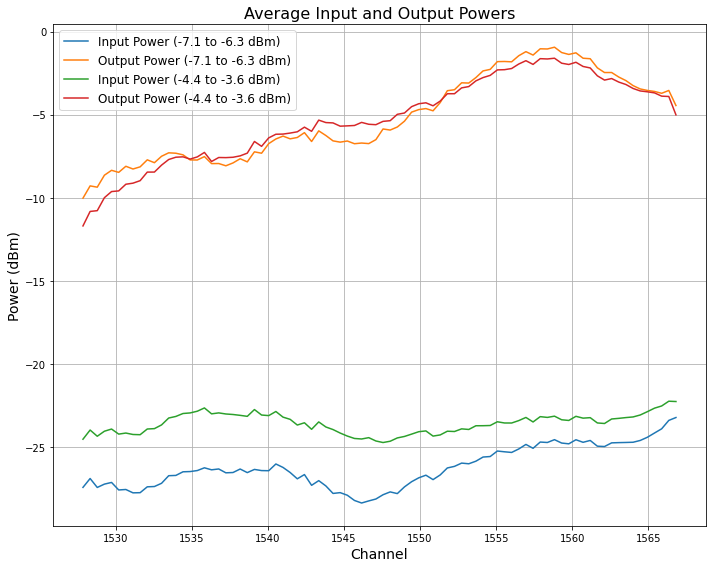

In [ ]:

# Load the dataset
df = pd.read_csv('Single_EDFA_Dataset.csv')

# Filter the rows with total input power between -7.1 to -6.3
filtered_df1 = df[(df['measuredTotalPin'] >= -7.1) & (df['measuredTotalPin'] <= -6.3)]

# Filter the rows with total input power between -4.4 to -3.6
filtered_df2 = df[(df['measuredTotalPin'] >= -4.4) & (df['measuredTotalPin'] <= -3.6)]

# Calculate the average power of input channels for both filtered dataframes
avg_input_powers1 = filtered_df1.iloc[:, 3:87].mean()
avg_input_powers2 = filtered_df2.iloc[:, 3:87].mean()

# Calculate the average power of output channels for both filtered dataframes
avg_output_powers1 = filtered_df1.iloc[:, 87:171].mean()
avg_output_powers2 = filtered_df2.iloc[:, 87:171].mean()

# Create a large plot
plt.figure(figsize=(10, 8))

# Plot average input powers for both filtered dataframes
plt.plot(channels, avg_input_powers1.values, label='Input Power (-7.1 to -6.3 dBm)' )
plt.plot(channels, avg_output_powers1.values, label='Output Power (-7.1 to -6.3 dBm)')

# Plot average output powers for both filtered dataframes
plt.plot(channels, avg_input_powers2.values, label='Input Power (-4.4 to -3.6 dBm)')
plt.plot(channels, avg_output_powers2.values, label='Output Power (-4.4 to -3.6 dBm)')

plt.title('Average Input and Output Powers', fontsize=16)
plt.ylabel('Power (dBm)', fontsize=14)
plt.xlabel('Channel', fontsize=14)
plt.legend(fontsize=12)

# Use grid
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

# Task 2a) Hyperparameter Tuning of the Artificial Neural Network (ANN) using `train_dense` Function

In this section, we are defining a function, `train_dense`, that will perform hyperparameter tuning for an ANN model. The objective of this function is to search through different configurations of the model, evaluating each for its performance, to find the optimal setup.

The `train_dense` function will accept three arguments:

1. `X_train`: This represents our training set of features.
2. `y_train`: These are the corresponding ground truth labels for the training set.
3. `resfiledense`: This is the file path for the results file. It is here where we will output the results of the training/optimization process.

The function will carry out the following tasks:

- Implement 5-fold cross-validation for the optimization of hyperparameters.
- Write the identified hyperparameters into the `resfiledense` file.
- Retrain the model with the best hyperparameters over the entire training set (`X_train`, `y_train`).
- Write the training results, including the best accuracy and training duration, into the `resfiledense` file.
- Return the trained model and a dictionary of the best hyperparameters.



In [ ]:
def train_dense(X_train, y_train, resfiledense):
    """
    This function performs hyperparameter optimization for a Dense Neural Network,
    trains the optimized model, and saves the results in a specified file.

    Parameters:
    X_train (numpy array): The features of the training dataset.
    y_train (DataFrame): The labels of the training dataset.
    resfiledense (str): The file path where the results are saved.

    Returns:
    model (keras model): The trained model.
    best_params (dict): The dictionary containing the best hyperparameters obtained from cross-validation.
    """

    # Cross-validation

    n_split_kfold = 5
    skf = KFold(n_splits=n_split_kfold, shuffle=True, random_state=42)

    best_params = {'hidden_units': [], 'activation': '', 'layers': 0, 'score': 1e10}
    layers_range = list(range(1, 4))  # change the upper limit to 4 to include 3 in the range
    activation_functions = ['relu', 'sigmoid']#, 'softmax']
    hidden_units_range = [128, 64, 32]
    scoreplot = {}

    t0 = time.time()
    for i, layers in enumerate(layers_range):  # Loop over the number of layers
        for j, activation in enumerate(activation_functions):  # Loop over activation functions
            for units in itertools.combinations(hidden_units_range, layers):  # Get combinations of hidden units
                print(f'Testing hyperparameters: layers: {layers}, activation: {activation}, hidden units: {units}')
                score = 0
                for train_index, test_index in skf.split(X_train, y_train):

                    X_train_fold, X_test_fold = X_train[train_index,:], X_train[test_index,:]
                    y_train_fold, y_test_fold = y_train.iloc[train_index,:], y_train.iloc[test_index,:]

                    # print(X_train_fold.shape, y_train_fold.shape)
                    model = Sequential()
                    model.add(Dense(units[0], activation=activation, input_dim=X_train.shape[1]))  # First layer with the largest number of units
                    for p in range(1, layers):
                        model.add(Dense(units[p], activation=activation))  # Subsequent layers with decreasing number of units
                    model.add(Dense(y_train.shape[1]))

                    model.compile(optimizer='adam', loss='mean_squared_error')

                    early_stopping = EarlyStopping(monitor='val_loss', patience=2)

                    model.fit(X_train_fold, y_train_fold, epochs=10, validation_split=0.2, verbose=0, callbacks=[early_stopping])
                    score += model.evaluate(X_test_fold, y_test_fold, verbose=0)

                model.summary()
                score = score / n_split_kfold
                scoreplot[(layers, activation, units)] = score
                print('score:', score)
                print('*************************************')
                if score < best_params['score']:  # Changed the '>' to '<'
                    best_params['score'] = score
                    best_params['hidden_units'] = units
                    best_params['activation'] = activation
                    best_params['layers'] = layers

    t1 = time.time()
    crossval_time = round(t1 - t0, 3)
    print('Crossval time [s]: ' + str(crossval_time))
    print('Best hyperparameters: ' + str(best_params))
    # print(scoreplot)

    # Retrain with the best_params and using the entire training set
    model = Sequential()
    model.add(Dense(best_params['hidden_units'][0], activation=best_params['activation'], input_dim=X_train.shape[1]))
    for i in range(1, best_params['layers']):
        model.add(Dense(best_params['hidden_units'][i], activation=best_params['activation']))
    model.add(Dense(y_train.shape[1]))

    t0 = time.time()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=10, verbose=0)
    t1 = time.time()
    training_time = round(t1 - t0, 3)
    final_score = model.evaluate(X_train, y_train, verbose=0)
    print('Score of the final model: ' + str(final_score))
    print(f'Best activation: {best_params["activation"]}.')
    print(f'Best number of layers: {best_params["layers"]}.')
    print(f'Best hidden units: {best_params["hidden_units"]}.')
    print('Training time [s]: ' + str(training_time))
    print('_________________________________________________________________\n')

    with open(resfiledense, 'w') as result_file:
        result_file.write('*** Dense ***\n')
        result_file.write('*** Crossvalidation results ***\n')
        result_file.write('Best activation: ' + str(best_params['activation']) + '\n')
        result_file.write('Best number of layers: ' + str(best_params['layers']) + '\n')
        result_file.write('Best hidden units: ' + str(best_params['hidden_units']) + '\n')
        result_file.write('Best crossvalidation accuracy: ' + str(best_params['score']) + '\n\n')

        result_file.write('*** Best model results (retrained with the entire training set) ***\n')
        result_file.write('Accuracy: ' + str(final_score) + '\n')
        result_file.write('Training duration [s]: ' + str(training_time) + '\n\n')

    return model, best_params

# Task 2b) Defining Evaluation Metrics Function
In this section, we'll define a function, `calculate_metrics()`, that will be used to evaluate the performance of our trained model. This function takes in three arguments: the model, the test data (`X_test`), and the true labels for the test data (`y_test`).

The function will return the MAE, MSE, and R^2 score.


In [ ]:
def calculate_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mae, mse, r2, y_pred

# Task 3a) Investigating the Impact of Normalization on Model Training and Performance

In this section, we will train two variants of an Artificial Neural Network (ANN) model: one with normalized input data and one without. This will allow us to evaluate the effect of input data normalization on the model's performance.

We will train both models on the same dataset, using Mean Squared Error (MSE) as the loss function and the Adam optimizer for training the neural networks. Each model will be trained for 50 epochs.

After training, the models will be tested on a separate testing dataset. The performance metrics we will use for comparison include Mean Squared Error (MSE), Mean Absolute Error (MAE), and R2 Score. We will also compare the training time for both models.


In [ ]:
df = pd.read_csv('Single_EDFA_Dataset.csv')
# Extract input features and output targets from the dataframe
X_full = df.iloc[:, 3:87]  # Input Channel Powers
y_full = df.iloc[:, 87:171]  # Output Channel Powers

# Split the complete dataset into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Normalize the input features using StandardScaler
# StandardScaler standardizes features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the normalization options for comparison
normalization_options = ['Normalized', 'Not Normalized']

# Prepare a list to store the results of each option
results = []

# Iterate through the normalization options
for normalization in normalization_options:
    # If the option is 'Normalized', use the scaled features
    if normalization == 'Normalized':
        X_train_used = X_train_scaled
        X_test_used = X_test_scaled
    else:  # Otherwise, use the original features
        X_train_used = X_train
        X_test_used = X_test

    # Define a Sequential model with a single hidden layer
    normalize_part_model = Sequential()
    normalize_part_model.add(Dense(128, activation='relu', input_dim=X_train_used.shape[1]))  # Hidden layer
    normalize_part_model.add(Dense(y_train.shape[1]))  # Output layer

    # Compile the model with the Adam optimizer and the mean squared error loss function
    normalize_part_model.compile(optimizer='adam', loss='mean_squared_error')

    # Record the start time and train the model
    start = time.time()
    normalize_part_model.fit(X_train_used, y_train, epochs=50, verbose=0)
    # Record the end time once training is complete
    end = time.time()

    # Calculate the mean squared error, mean absolute error, and R2 score of the predictions
    mae, mse, r2, y_pred = calculate_metrics(normalize_part_model, X_test, y_test)

    # Store the results in the results list
    results.append({
        'normalization': normalization,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'training_time': end - start,
        'model': normalize_part_model,
        'predction': y_pred
    })


# Output the results
for result in results:
    print(f"\nNormalization: {result['normalization']}")
    print(f"MSE: {result['mse']}")
    print(f"MAE: {result['mae']}")
    print(f"R2 Score: {result['r2']}")
    print(f"Training Time: {result['training_time']}")  # Display the time taken to train each model
    print(f"predction save has shape of: {result['predction'].shape}")




Normalization: Normalized
MSE: 258.3081538033318
MAE: 12.822741690571066
R2 Score: -70.27640729344546
Training Time: 45.97920823097229


AttributeError: 'str' object has no attribute 'shape'

# Task 3a') Visualization of the Impact of Normalization on Model Training and Performance

In this part of the task, we will visualize the comparison between the actual and predicted output channel powers for both models, i.e., the one trained with normalized inputs and the one without normalization.

For each model, we use the respective model to predict the output powers on the testing data set, and then plot the actual and predicted powers for a clear comparison.

**N.B. Observation: Through these graphs, we can find that the Normalized dataset provide a significant better result than the one without using normalized dataset**


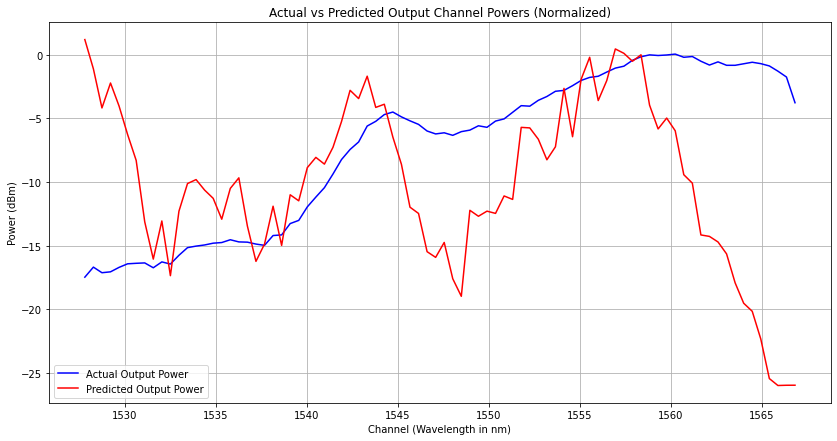

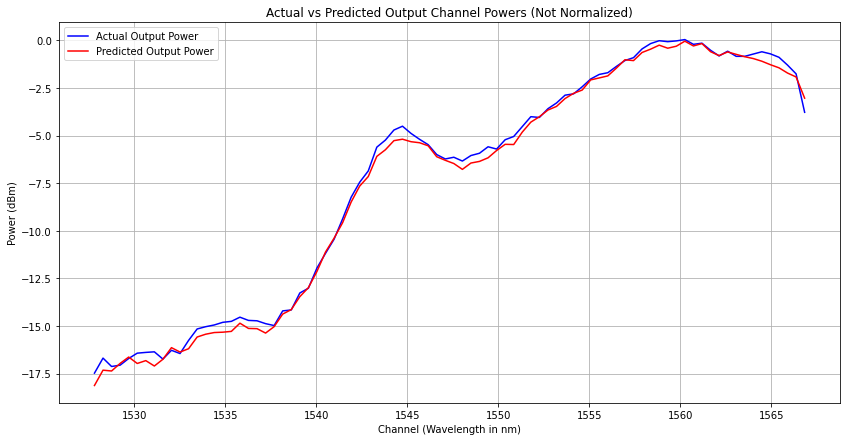

In [ ]:
for result in results:
    # Get the predicted output
    y_pred = result['predction']

    # Plot actual vs predicted output
    plt.figure(figsize=(14, 7))
    plt.plot(channels, y_test.values[0], 'b-', label='Actual Output Power')
    plt.plot(channels, y_pred[0], 'r-', label='Predicted Output Power')
    plt.title(f'Actual vs Predicted Output Channel Powers ({result["normalization"]})')
    plt.xlabel('Channel (Wavelength in nm)')
    plt.ylabel('Power (dBm)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
traing_sizes = np.arange(0.5,0.95,0.05)

# Task 3b) Evaluating the Impact of Training Size on Model Performance

In this part of the task, we investigate how the training size affects the performance of our Artificial Neural Network (ANN) model. By varying the proportion of the dataset used for training, we can analyze the model's behavior and determine the optimal training size.

We define a list of different training sizes, ranging from 50% to 90% of the entire dataset. For each training size, we split the dataset into a training set and a testing set. Then, we normalize the input features using the StandardScaler to ensure consistency.

Next, we create a Sequential model with a hidden layer of 128 units and compile it with the Adam optimizer and mean squared error loss function.

We train the model using the training set and record the training time. After training, we predict the output powers on the testing set and calculate performance metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R2 Score.

We store the results for each training size, including the training size itself, MSE, MAE, R2 Score, and the training time.


In [ ]:
# Define a list of different proportions of the dataset to use for training
training_sizes = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

# Initialize an empty list to store the results of each training size
results = []

# Iterate through the list of training sizes
for training_size in training_sizes:
    # Calculate the proportion of the dataset to use for testing
    test_size = 1 - training_size

    # Split the dataset into training and testing subsets
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=test_size, random_state=42)

    # Normalize the features to a standard scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create a Sequential model with two layers
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]))
    model.add(Dense(y_train.shape[1]))

    # Compile the model with the Adam optimizer and mean squared error loss function
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Record the start time of training
    start = time.time()
    # Train the model
    model.fit(X_train_scaled, y_train, epochs=50, verbose=0)
    # Record the end time of training
    end = time.time()

    # Use the trained model to predict the output powers on the testing set
    y_pred = model.predict(X_test_scaled)

    # Calculate the mean squared error, mean absolute error, and r2 score of the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the results for this training size
    results.append({
        'training_size': training_size,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'training_time': end - start,
        'model': model
    })

# Print the results for each training size
for result in results:
    print(f"Training size: {result['training_size']}, MSE: {result['mse']}, MAE: {result['mae']}, R2: {result['r2']}, Training time: {result['training_time']}")


Training size: 0.5, MSE: 0.01745988573655694, MAE: 0.0912736217890354, R2: 0.9958685133937544, Training time: 24.722975969314575
Training size: 0.55, MSE: 0.019014559643604285, MAE: 0.09604159802843486, R2: 0.9957413857639924, Training time: 26.040553092956543
Training size: 0.6, MSE: 0.015017965170893507, MAE: 0.08476969366124734, R2: 0.9963161532578281, Training time: 29.933094263076782
Training size: 0.65, MSE: 0.024539128007124787, MAE: 0.11355803318107908, R2: 0.994708879798698, Training time: 35.65815711021423
Training size: 0.7, MSE: 0.013848057456469089, MAE: 0.08224992817095197, R2: 0.9965573954925954, Training time: 34.544597148895264
Training size: 0.75, MSE: 0.013393707751389962, MAE: 0.08048048762421496, R2: 0.9966048470669518, Training time: 37.68354630470276
Training size: 0.8, MSE: 0.013075695733994877, MAE: 0.08003458711414192, R2: 0.9965737478331261, Training time: 39.6780526638031
Training size: 0.85, MSE: 0.012610366111295188, MAE: 0.07838895841162685, R2: 0.9967688

# Task 3b') Visualizing the Impact of Training Size on Model Performance

In this section, we visualize the impact of training size on the performance of our Artificial Neural Network (ANN) model. We plot various metrics against different training sizes to gain insights into how the size of the training data affects the model's performance.

We extract the relevant metrics, including Mean Squared Error (MSE), Mean Absolute Error (MAE), R2 Score, and Training Time, from the results obtained in the previous step.

Using `matplotlib.pyplot`, we create a 2x2 grid of subplots to display the metrics. Each subplot represents one metric, and the x-axis represents the training size, ranging from 50% to 90% of the dataset.

For each metric, we plot the values against the corresponding training sizes using markers to visualize the data points.

The four subplots are as follows:
1. Mean Squared Error (MSE) vs Training Size
2. Mean Absolute Error (MAE) vs Training Size
3. R2 Score vs Training Size
4. Training Time vs Training Size

**N.B. Observation: the graphs show that training size at about 80% is a good choice, lower or higher will cause to a performance drop.**

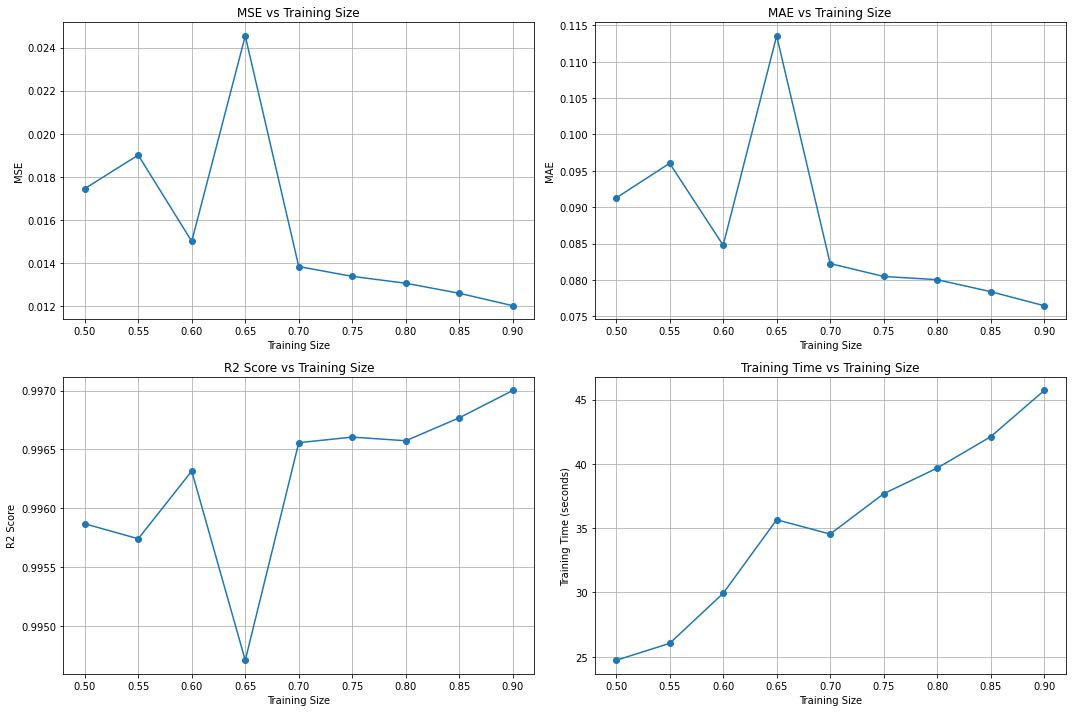

In [ ]:
import matplotlib.pyplot as plt

# Extract the results into separate lists
training_sizes = [result['training_size'] for result in results]
mses = [result['mse'] for result in results]
maes = [result['mae'] for result in results]
r2s = [result['r2'] for result in results]
training_times = [result['training_time'] for result in results]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot MSE
axs[0, 0].plot(training_sizes, mses, marker='o')
axs[0, 0].set_title('MSE vs Training Size')
axs[0, 0].set_xlabel('Training Size')
axs[0, 0].set_ylabel('MSE')
axs[0, 0].grid(True)

# Plot MAE
axs[0, 1].plot(training_sizes, maes, marker='o')
axs[0, 1].set_title('MAE vs Training Size')
axs[0, 1].set_xlabel('Training Size')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].grid(True)

# Plot R2
axs[1, 0].plot(training_sizes, r2s, marker='o')
axs[1, 0].set_title('R2 Score vs Training Size')
axs[1, 0].set_xlabel('Training Size')
axs[1, 0].set_ylabel('R2 Score')
axs[1, 0].grid(True)

# Plot Training Time
axs[1, 1].plot(training_sizes, training_times, marker='o')
axs[1, 1].set_title('Training Time vs Training Size')
axs[1, 1].set_xlabel('Training Size')
axs[1, 1].set_ylabel('Training Time (seconds)')
axs[1, 1].grid(True)

# Improve layout
fig.tight_layout()
plt.show()


# Task 4a) Evaluating the Impact of Different Intervals and Perform Fine-Tuning with ANN Machine Learning

In this task, we aim to evaluate the impact of different channel intervals on the performance of the ANN machine learning model. We will also perform fine-tuning using all the intervals to optimize the model's hyperparameters.

1. Test the Impact of Different Intervals:

2. Perform Fine-Tuning with ANN Machine Learning:



In [ ]:
channel_intervals = [1, 2, 5, 10]

# Results storage
ANN_results = []

for interval in channel_intervals:
    print(f'Processing interval: {interval}\n')

    # Generate the dataset for the current interval
    generated_df, generated_train_data, generated_train_label = generatedataset(file_dir, sampling_index=interval)
    print('Check the size of train_data and train_label:')
    print(f'Train_data size: {generated_train_data.shape}')
    print(f'Train_label size: {generated_train_label.shape}')
    print('_________________________________________________________________\n')

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(generated_train_data)

    # Split the dataset into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, generated_train_label, test_size=0.2, random_state=42)

    # Create a results file specific to the interval
    resf = f'ANN_results_interval_{interval}.txt'

    # Train the model with hyperparameter tuning
    model, best_params = train_dense(X_train, y_train, resf)

    # Calculate the metrics
    mae, mse, r2 = calculate_metrics(model, X_test, y_test)

    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"R^2 Score: {r2}")

    print('_________________________________________________________________\n\n')

    # Adding metrics to the results file
    with open(resf, 'a') as result_file:
        result_file.write(f"Mean Absolute Error (MAE): {mae}\n")
        result_file.write(f"Mean Squared Error (MSE): {mse}\n")
        result_file.write(f"R^2 Score: {r2}\n")

    # Store the results and the metrics
    ANN_results.append({
        'interval': interval,
        'model': model,
        'best_params': best_params,
        'mae': mae,
        'mse': mse,
        'r2': r2
    })

Processing interval: 1

Check the size of train_data and train_label:
Train_data size: (16497, 84)
Train_label size: (16497, 84)
_________________________________________________________________

Testing hyperparameters: layers: 1, activation: relu, hidden units: (128,)
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 128)               10880     
_________________________________________________________________
dense_32 (Dense)             (None, 84)                10836     
Total params: 21,716
Trainable params: 21,716
Non-trainable params: 0
_________________________________________________________________
score: 0.06202934240614576
*************************************
Testing hyperparameters: layers: 1, activation: relu, hidden units: (64,)
Model: "sequential_21"
_________________________________________________________________
Layer (type)

In [ ]:
# Display the ANN_results
for result in ANN_results:
    print(f"Interval: {result['interval']}")
    print(f"Best Parameters: {result['best_params']}")
    print(f"Mean Absolute Error (MAE): {result['mae']}")
    print(f"Mean Squared Error (MSE): {result['mse']}")
    print(f"R^2 Score: {result['r2']}")
    print("-----------------------------------------------------------------\n")


Interval: 1
Best Parameters: {'hidden_units': (128,), 'activation': 'relu', 'layers': 1, 'score': 0.06202934240614576}
Mean Absolute Error (MAE): 0.14436514909784062
Mean Squared Error (MSE): 0.042149940939562
R^2 Score: 0.9901715785239587
-----------------------------------------------------------------

Interval: 2
Best Parameters: {'hidden_units': (128, 64), 'activation': 'relu', 'layers': 2, 'score': 0.062103222092115204}
Mean Absolute Error (MAE): 0.14993017870081204
Mean Squared Error (MSE): 0.04478169728202129
R^2 Score: 0.9892291182413327
-----------------------------------------------------------------

Interval: 5
Best Parameters: {'hidden_units': (128, 64), 'activation': 'relu', 'layers': 2, 'score': 0.07348554997292546}
Mean Absolute Error (MAE): 0.16797692551906165
Mean Squared Error (MSE): 0.0564110653690084
R^2 Score: 0.986792491767221
-----------------------------------------------------------------

Interval: 10
Best Parameters: {'hidden_units': (128, 64), 'activation'

# Task 4a') Plot the Impact of Different Intervals on Predicted Output Channel Powers

In this task, we explore the impact of different channel intervals on the prediction accuracy of output channel powers. We first generate the dataset for the default interval of 1, and then scale the features. The dataset is split into training and testing sets.

For each interval in the `channel_intervals` list, we select the first row of the test set with the corresponding interval. We use the trained model for that interval to make predictions on the selected row. The predicted output powers for each interval are stored in the `predictions` list.

Finally, we plot the actual output power and the predicted output powers for the first test example. The plot shows a comparison between the actual output power and the predicted output powers for different channel intervals, highlighting the impact of different intervals on the prediction accuracy.

**N.B. Observation: From the graph, it seems with channel interval equal to 5 is a good choice, there is not too much performance drop, but with interval equal to 10 there is a significant profromance drop.**

[   0    1    2 ... 3297 3298 3299]
1111


1527.82   -8.063
1528.29   -7.443
1528.76   -8.053
1529.23   -6.963
1529.70   -6.833
           ...  
1564.95   -5.053
1565.42   -5.323
1565.89   -5.763
1566.36   -5.533
1566.83   -5.913
Name: 8297, Length: 84, dtype: float64

(1, 84)
(1, 84)
(1, 84)
(1, 84)


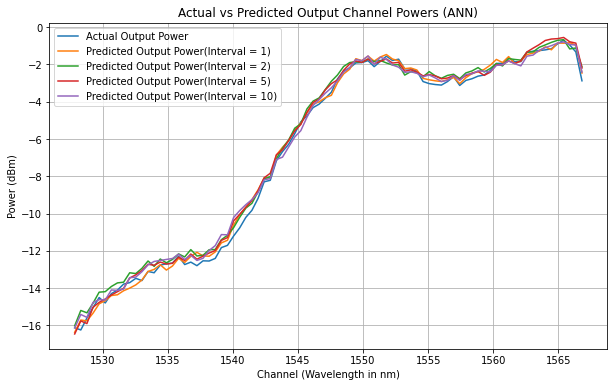

In [ ]:
# Generate the dataset for the current interval
generated_df, generated_train_data, generated_train_label = generatedataset(file_dir, sampling_index=1)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(generated_train_data)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, generated_train_label, test_size=0.2, random_state=42)

index = np.arange(y_test.shape[0])
np.random.shuffle(index)
random_index =index[0]
# randomly Select one example from the test and predicted sets
y_test_example = y_test.iloc[random_index]

predictions = []
i = 0

for interval in channel_intervals:
    # Select the first row of the test set
    row = X_test[random_index][::interval]
    # Convert the row to 2D array
    row_2D = np.expand_dims(row, axis=0)
    # Use the model to make a prediction
    prediction = ANN_results[i]['model'].predict(row_2D) # here the model will take 2d dimension or say (1,XX) as input

    i = i + 1

    predictions.append(prediction)

# Plot the real output and the predicted outputs for the first test example
plt.figure(figsize=(10, 6))

plt.plot(channels, y_test.iloc[random_index], label='Actual Output Power')

for i, interval in enumerate(channel_intervals):

    plt.plot(channels, predictions[i][0], label=f'Predicted Output Power(Interval = {interval})')

plt.title(f'Actual vs Predicted Output Channel Powers (ANN)')
plt.xlabel('Channel (Wavelength in nm)')
plt.ylabel('Power (dBm)')
plt.legend()
plt.grid(True)
plt.show()



4

# Task 5a) Evaluating Linear Regression Model Performance

In this task, we will evaluate the performance of the Linear Regression model on unseen data. We will utilize the trained models obtained from the previous task and assess their effectiveness in predicting the output channel powers.

The procedure involves the following steps:

1. Load the test dataset, which includes the input features (`X_test`) and the corresponding target values (`y_test`).

2. Iterate through the `Linear_results` list to access the trained Linear Regression models.

3. Utilize each model to predict the output channel powers for the test dataset.

4. Calculate the evaluation metrics, such as the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R^2 score, by comparing the predicted values with the actual values.

5. Print the evaluation metrics for each model.

**N.B. Observation: with the inerval increrase, the performance will drop. So it's better to keep the features as many as possbileas at the input.**


In [ ]:
# Initialize the list to hold all models and metrics
Linear_results = []

for sampling_index in channel_intervals:
    # Generate the dataset and split it
    _, generated_train_data, generated_train_label = generatedataset(file_dir, sampling_index=sampling_index)

    # Scaling the data
    scaler = StandardScaler()
    X = scaler.fit_transform(generated_train_data)
    y = generated_train_label

    # Initialize the Linear Regression model
    lin_reg = LinearRegression()

    # Perform k-fold cross-validation
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_r2_scores = cross_val_score(lin_reg, X, y, cv=cv, scoring='r2')
    cv_mse_scores = cross_val_score(lin_reg, X, y, cv=cv, scoring='neg_mean_squared_error')
    cv_mae_scores = cross_val_score(lin_reg, X, y, cv=cv, scoring='neg_mean_absolute_error')

    # Fit the model to the entire dataset
    lin_reg.fit(X, y)

    # Create a dictionary with the Linear_results and add it to the list
    Linear_results.append({
        'sampling_index': sampling_index,
        'model': lin_reg,
        'mse_scores': -cv_mse_scores, # Multiply by -1 because sklearn returns negative values
        'mse_mean': -cv_mse_scores.mean(),
        'mae_scores': -cv_mae_scores,
        'mae_mean': -cv_mae_scores.mean(),
        'r2_scores': cv_r2_scores,
        'r2_mean': cv_r2_scores.mean()
    })

# Print the Linear_results
for result in Linear_results:
    print(f"--- Sampling Index: {result['sampling_index']} ---")
    print(f"Mean Squared Error (MSE) Cross-Val Mean Score: {result['mse_mean']}")
    print(f"Mean Absolute Error (MAE) Cross-Val Mean Score: {result['mae_mean']}")
    print(f"R^2 Cross-Val Mean Score: {result['r2_mean']}\n")

--- Sampling Index: 1 ---
Mean Squared Error (MSE) Cross-Val Mean Score: 0.144275026517003
Mean Absolute Error (MAE) Cross-Val Mean Score: 0.2466313745362839
R^2 Cross-Val Mean Score: 0.9655341194887713

--- Sampling Index: 2 ---
Mean Squared Error (MSE) Cross-Val Mean Score: 0.19941281014560966
Mean Absolute Error (MAE) Cross-Val Mean Score: 0.2900935274155352
R^2 Cross-Val Mean Score: 0.9529322673289291

--- Sampling Index: 5 ---
Mean Squared Error (MSE) Cross-Val Mean Score: 0.37704153512022864
Mean Absolute Error (MAE) Cross-Val Mean Score: 0.43461531895699446
R^2 Cross-Val Mean Score: 0.911499633778486

--- Sampling Index: 10 ---
Mean Squared Error (MSE) Cross-Val Mean Score: 0.47925593145804396
Mean Absolute Error (MAE) Cross-Val Mean Score: 0.4751675905231473
R^2 Cross-Val Mean Score: 0.8902015478749801



# Task 6a) Comparison of Linear and ANN Models

In this task, we compare the performance of the Linear Regression and Artificial Neural Network (ANN) models in predicting the output channel powers. We generate predictions for different channel intervals and visualize the actual and predicted output powers for the first test example.

The code then creates a subplot with two columns to display the visualizations. In the left subplot, it plots the actual output power and the predicted output powers from the ANN model for different intervals. Each line represents a different interval value. In the right subplot, it plots the actual output power and the predicted output powers from the Linear Regression model for different intervals.

**N.B. Observation: By comparing the plots, we can found that ANN models perform way better than the Linear Regression.**


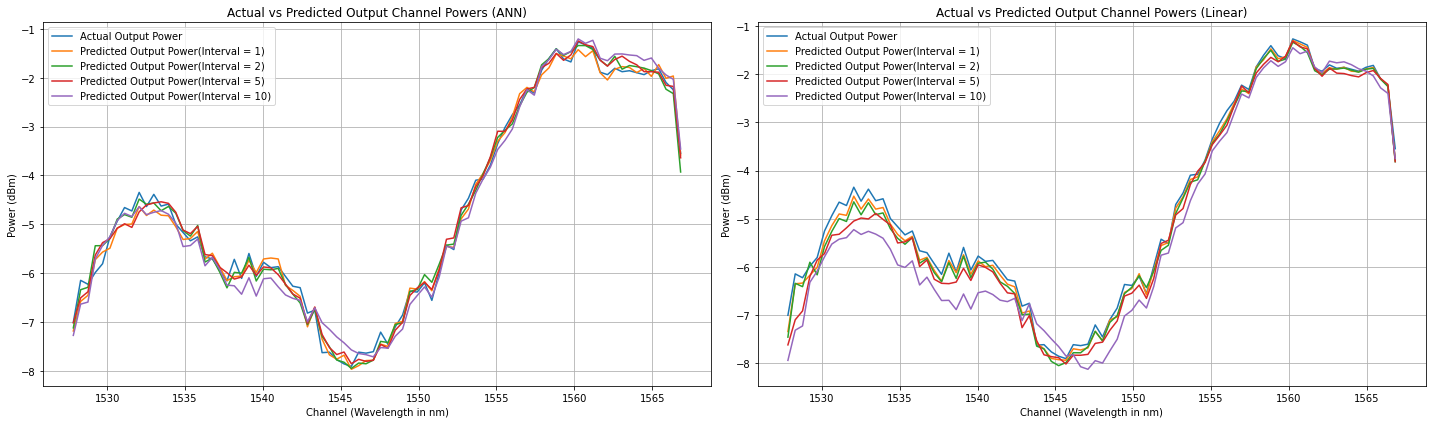

In [ ]:
# Generate the dataset for the current interval
generated_df, generated_train_data, generated_train_label = generatedataset(file_dir, sampling_index=1)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(generated_train_data)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, generated_train_label, test_size=0.2, random_state=42)

# Select one example from the test and predicted sets
index = np.arange(y_test.shape[0])
np.random.shuffle(index)
random_index =index[0]
# randomly Select one example from the test and predicted sets
y_test_example = y_test.iloc[random_index]

# Initialize two lists to hold predictions from the ANN and Linear Regression models
ann_predictions = []
linear_predictions = []

for i, interval in enumerate(channel_intervals):
    # Select the first row of the test set
    row = X_test[random_index][::interval]

    # Convert the row to 2D array
    row_2D = np.expand_dims(row, axis=0)

    # Use the ANN and Linear models to make predictions
    ann_prediction = ANN_results[i]['model'].predict(row_2D)
    linear_prediction = Linear_results[i]['model'].predict(row_2D)

    # Store the predictions for the first test example
    ann_predictions.append(ann_prediction)
    linear_predictions.append(linear_prediction)

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Plot the real output and the predicted outputs for the first test example from the ANN model
axs[0].plot(channels, y_test.iloc[random_index], label='Actual Output Power')

for i, interval in enumerate(channel_intervals):
    axs[0].plot(channels, ann_predictions[i][0], label=f'Predicted Output Power(Interval = {interval})')
axs[0].set_title(f'Actual vs Predicted Output Channel Powers (ANN)')
axs[0].set_xlabel('Channel (Wavelength in nm)')
axs[0].set_ylabel('Power (dBm)')
axs[0].legend()
axs[0].grid(True)

# Plot the real output and the predicted outputs for the first test example from the Linear Regression model
axs[1].plot(channels, y_test.iloc[random_index], label='Actual Output Power')

for i, interval in enumerate(channel_intervals):
    axs[1].plot(channels, linear_predictions[i][0], label=f'Predicted Output Power(Interval = {interval})')
axs[1].set_title(f'Actual vs Predicted Output Channel Powers (Linear)')
axs[1].set_xlabel('Channel (Wavelength in nm)')
axs[1].set_ylabel('Power (dBm)')
axs[1].legend()
axs[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()

# Task 6b) Comparison of Linear and ANN Model Performance Metrics

In this task, we compare the performance metrics of the Artificial Neural Network (ANN) and Linear Regression models. We extract the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R^2 scores for different intervals and visualize the comparisons.

The code extracts the corresponding metrics from the `ANN_results` and `Linear_results` lists. It retrieves the MSE, MAE, and R^2 scores for each interval.

The x-axis represents the intervals, and the y-axis represents the mean value of the metric. Each model is represented by a line with markers. The ANN model is shown with markers connected by lines, and the Linear Regression model is shown with markers connected by lines.

**N.B. Observation: It is more clear with the metrics that we could find better performance using ANN machine learning, even with fewer inputs we still have better metrics than using Linear Regreassion**

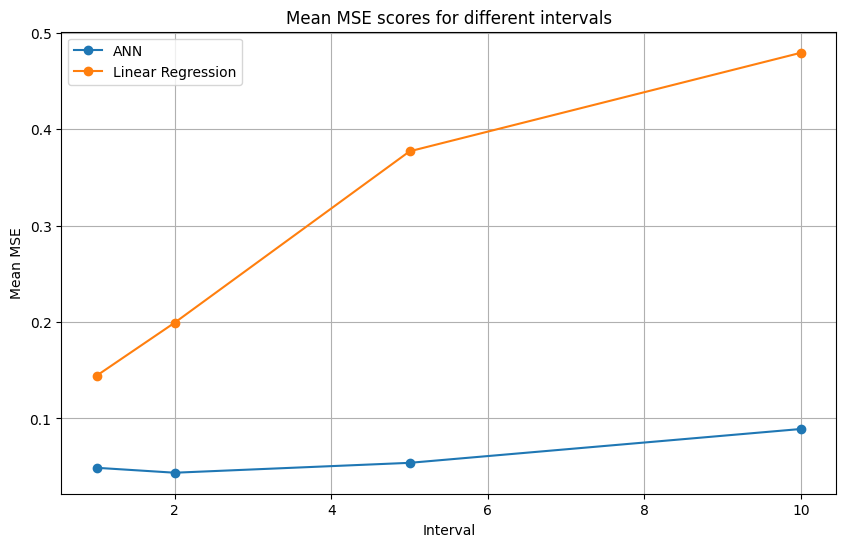

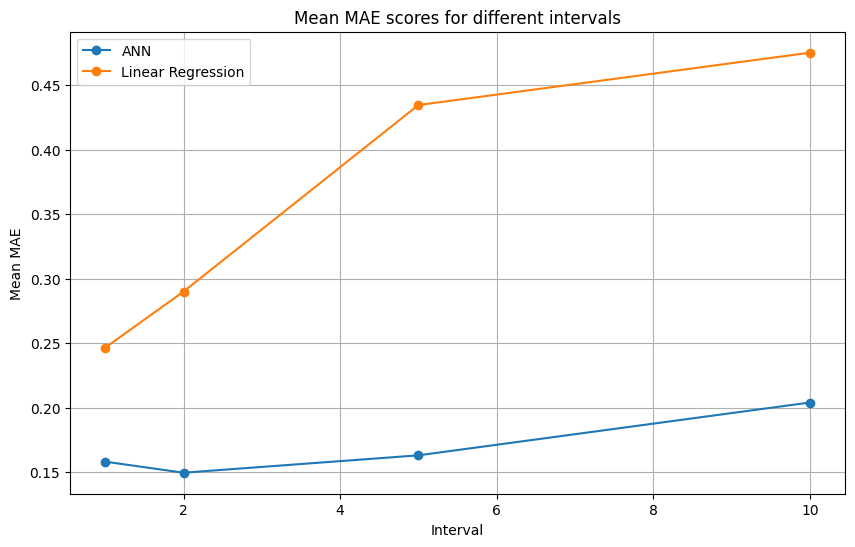

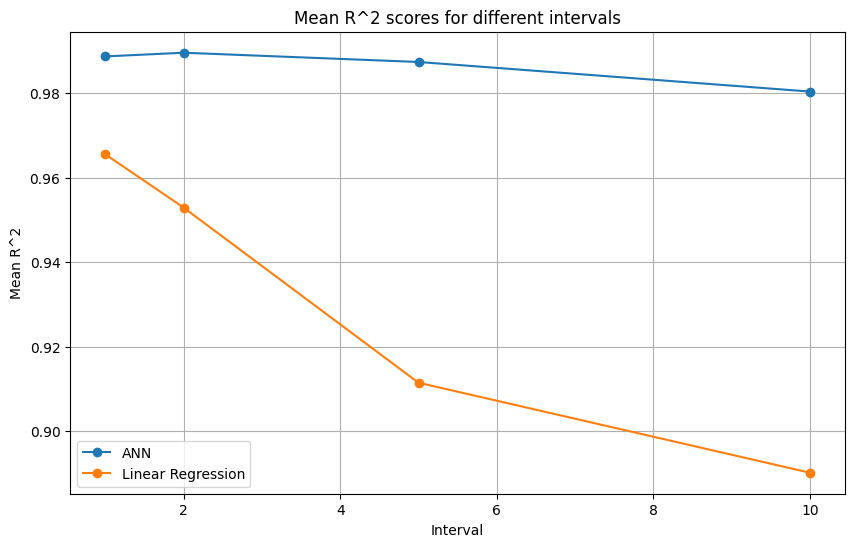

In [ ]:
# Extract metrics from ANN_results
ANN_mse = [result['mse'] for result in ANN_results]
ANN_mae = [result['mae'] for result in ANN_results]
ANN_r2 = [result['r2'] for result in ANN_results]

# Extract metrics from Linear_results
Linear_mse = [result['mse_mean'] for result in Linear_results]
Linear_mae = [result['mae_mean'] for result in Linear_results]
Linear_r2 = [result['r2_mean'] for result in Linear_results]

# Define intervals
intervals = [result['interval'] for result in ANN_results]

# Plot MSE comparison
plt.figure(figsize=(10, 6))
plt.plot(intervals, ANN_mse, marker='o', label='ANN')
plt.plot(intervals, Linear_mse, marker='o', label='Linear Regression')
plt.title('Mean MSE scores for different intervals')
plt.xlabel('Interval')
plt.ylabel('Mean MSE')
plt.grid(True)
plt.legend()
plt.show()

# Plot MAE comparison
plt.figure(figsize=(10, 6))
plt.plot(intervals, ANN_mae, marker='o', label='ANN')
plt.plot(intervals, Linear_mae, marker='o', label='Linear Regression')
plt.title('Mean MAE scores for different intervals')
plt.xlabel('Interval')
plt.ylabel('Mean MAE')
plt.grid(True)
plt.legend()
plt.show()

# Plot R^2 comparison
plt.figure(figsize=(10, 6))
plt.plot(intervals, ANN_r2, marker='o', label='ANN')
plt.plot(intervals, Linear_r2, marker='o', label='Linear Regression')
plt.title('Mean R^2 scores for different intervals')
plt.xlabel('Interval')
plt.ylabel('Mean R^2')
plt.grid(True)
plt.legend()
plt.show()


# Task 7) Advanced Task: Transfer learning

In this task, we explore the concept of transfer learning in the context of our problem. Transfer learning allows us to leverage pre-trained models on a different but related task to improve the performance on our specific task. We analyze the data accoring to their total input powers and see the number of fiels distribution to make a fair data selection.

**N.B. Observation: We separate the file according to the TotalPin. And it can be seen that the number of files in the different groups does not change too much. We can select files relatively fair. And the predictions using transfer learning are little worse than the original one. But with less traing data can obtain the 80-90% performance we'd like to say the transfer learning method works!**


# Task 7a) Data analysis

In this section, we will try to divide the data according to the total input power and try to make a brief statement to the divided data strucutre which will help us to identify the data feasibility. The data structure will be plot in a form of histogram.

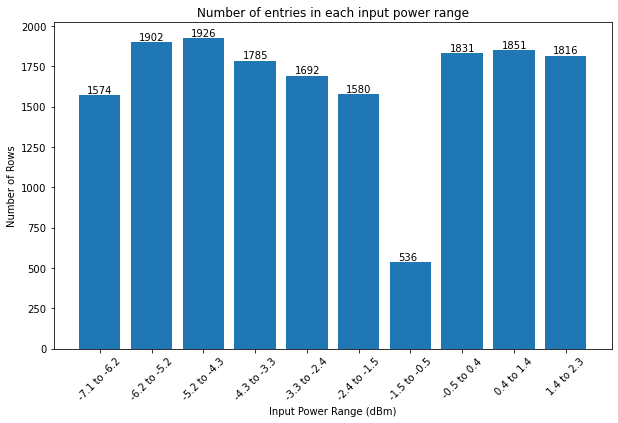

In [ ]:
# Load the data
df = pd.read_csv('Single_EDFA_Dataset.csv')

# Calculate min, max and range
min_val = df['measuredTotalPin'].min()
max_val = df['measuredTotalPin'].max()
range_val = max_val - min_val

# Calculate bin width and create bins
bin_width = range_val / 10
bins = np.arange(min_val, max_val + bin_width - 0.01, bin_width) # add bin_width with -0.01 in order not to create another bin

# Segment data into bins and count rows in each bin
df['bin'] = pd.cut(df['measuredTotalPin'], bins) # segment the df according to their measured total pin values
bin_counts = df['bin'].value_counts().sort_index() # first count the number of entris of every segmented data frame then sort them by decreasing numbers

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(bin_counts)), bin_counts,
        tick_label=[f'{i.left:.1f} to {i.right:.1f}' for i in bin_counts.index])

# Add counts on the top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/5, yval, int(yval), va='bottom')  # va: vertical alignment

plt.title('Number of entries in each input power range')
plt.xlabel('Input Power Range (dBm)')
plt.ylabel('Number of Rows')
plt.xticks(rotation=45)
plt.show()


In [ ]:
df['bin']

0           (1.36, 2.3]
1          (0.42, 1.36]
2         (-0.52, 0.42]
3         (-2.4, -1.46]
4         (-3.34, -2.4]
              ...      
16492     (-2.4, -1.46]
16493     (-3.34, -2.4]
16494    (-5.22, -4.28]
16495    (-5.22, -4.28]
16496    (-6.16, -5.22]
Name: bin, Length: 16497, dtype: category
Categories (10, interval[float64, right]): [(-7.1, -6.16] < (-6.16, -5.22] < (-5.22, -4.28] < (-4.28, -3.34] ... (-1.46, -0.52] < (-0.52, 0.42] < (0.42, 1.36] < (1.36, 2.3]]

# Task 7b) Data  generation

In this section, we will use the selected range to extract the data as traing data and labels for the transfer learning model. And use the left dataset as test dataset.

In [ ]:
# Randomly choose two bins
bins_unique = df['bin'].unique().dropna()  # Get unique bins and drop NaN values
domain_A_bin, domain_B_bin = np.random.choice(bins_unique, 2, replace=False)

# Select data from these bins
domain_A = df[df['bin'] == domain_A_bin]
domain_B = df[df['bin'] == domain_B_bin]

# Show the information
print(f"Domain A (Source) dataset:\nBin range: {domain_A_bin.left:.1f} to {domain_A_bin.right:.1f}\nShape: {domain_A.shape}\nSize: {domain_A.size}\n")
domain_A

Domain A (Source) dataset:
Bin range: -0.5 to 0.4
Shape: (1831, 172)
Size: 314932



,profileId,measuredTotalPin,measuredTotalPout,inat152782,inat152829,inat152876,inat152923,inat152970,inat153017,inat153064,...,outat156307,outat156354,outat156401,outat156448,outat156495,outat156542,outat156589,outat156636,outat156683,bin
2,1002,-0.046481,15.0,-21.227,-20.627,-21.417,-20.827,-20.847,-20.797,-20.807,...,-1.275,-1.295,-1.375,-1.455,-1.385,-1.265,-1.365,-1.515,-2.945,"(-0.52, 0.42]"
11,10030,0.200000,15.0,-26.614,-25.534,-26.354,-26.484,-26.174,-26.234,-25.754,...,-1.619,-1.859,-2.109,-2.339,-2.449,-2.489,-2.549,-2.649,-4.309,"(-0.52, 0.42]"
20,10043,-0.046481,14.9,-19.839,-18.899,-19.089,-18.589,-18.779,-18.779,-18.789,...,-2.390,-2.430,-2.650,-2.780,-2.890,-2.980,-3.190,-3.180,-4.160,"(-0.52, 0.42]"
29,10081,-0.100000,15.0,-19.574,-19.114,-18.904,-19.174,-19.004,-19.264,-19.254,...,-1.139,-1.129,-1.049,-1.129,-1.089,-1.019,-1.069,-1.219,-2.789,"(-0.52, 0.42]"
38,10087,-0.046481,15.0,-19.682,-18.442,-18.712,-18.322,-18.662,-18.972,-19.292,...,-2.144,-2.574,-3.164,-3.724,-4.204,-4.674,-4.974,-5.184,-5.444,"(-0.52, 0.42]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16454,9968,-0.400000,15.0,-14.230,-13.810,-14.250,-13.370,-13.910,-14.910,-15.020,...,-6.875,-6.945,-7.485,-7.655,-7.715,-7.845,-8.235,-8.175,-8.365,"(-0.52, 0.42]"
16463,9975,-0.046481,15.0,-19.917,-19.487,-19.447,-19.627,-19.407,-19.637,-19.597,...,-1.687,-1.807,-1.897,-2.017,-2.007,-1.937,-2.017,-2.007,-3.567,"(-0.52, 0.42]"
16472,9983,-0.100000,15.0,-17.050,-17.620,-17.650,-17.110,-16.930,-16.990,-17.030,...,-3.774,-3.964,-4.224,-4.394,-4.484,-4.624,-4.954,-5.014,-5.974,"(-0.52, 0.42]"
16481,9984,-0.046481,15.0,-24.782,-24.132,-24.662,-24.192,-24.082,-24.812,-24.812,...,-0.267,-0.197,0.143,0.293,0.523,0.413,-0.107,-0.567,-1.447,"(-0.52, 0.42]"


In [ ]:
print(f"Domain B (Target) dataset:\nBin range: {domain_B_bin.left:.1f} to {domain_B_bin.right:.1f}\nShape: {domain_B.shape}\nSize: {domain_B.size}\n")
domain_B


Domain B (Target) dataset:
Bin range: -5.2 to -4.3
Shape: (1926, 172)
Size: 331272



,profileId,measuredTotalPin,measuredTotalPout,inat152782,inat152829,inat152876,inat152923,inat152970,inat153017,inat153064,...,outat156307,outat156354,outat156401,outat156448,outat156495,outat156542,outat156589,outat156636,outat156683,bin
6,1002,-4.5,15.0,-26.080,-25.090,-26.150,-25.560,-25.410,-25.550,-25.580,...,-2.304,-2.364,-2.654,-2.794,-2.764,-2.674,-2.664,-2.464,-3.644,"(-5.22, -4.28]"
15,10030,-4.6,15.0,-31.219,-30.109,-31.399,-31.509,-31.379,-31.629,-31.189,...,-2.382,-2.692,-3.102,-3.562,-3.692,-3.622,-3.552,-3.442,-4.672,"(-5.22, -4.28]"
24,10043,-4.5,15.0,-23.932,-23.292,-23.742,-23.142,-23.062,-23.712,-23.682,...,-3.490,-3.700,-3.910,-4.170,-4.330,-4.410,-4.610,-4.530,-5.300,"(-5.22, -4.28]"
33,10081,-4.6,15.0,-23.685,-23.565,-23.535,-23.625,-23.715,-24.265,-24.005,...,-2.196,-2.336,-2.476,-2.616,-2.536,-2.456,-2.436,-2.336,-3.596,"(-5.22, -4.28]"
42,10087,-4.8,15.0,-23.496,-22.586,-23.096,-22.596,-22.836,-23.926,-24.026,...,-3.097,-3.617,-4.287,-4.947,-5.447,-5.937,-6.497,-6.547,-6.387,"(-5.22, -4.28]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16467,9975,-4.5,15.0,-24.163,-24.063,-23.973,-24.243,-24.283,-24.523,-24.323,...,-2.832,-2.992,-3.192,-3.452,-3.452,-3.482,-3.422,-3.222,-4.372,"(-5.22, -4.28]"
16476,9983,-4.5,15.0,-21.689,-21.819,-21.909,-21.539,-21.409,-21.529,-21.369,...,-5.147,-5.117,-5.707,-6.007,-6.117,-6.307,-6.737,-6.707,-9.217,"(-5.22, -4.28]"
16485,9984,-4.9,15.0,-30.054,-28.914,-29.484,-29.104,-29.544,-30.034,-30.294,...,-0.964,-1.004,-0.984,-0.874,-0.614,-0.224,-0.324,-0.594,-2.194,"(-5.22, -4.28]"
16494,9998,-4.3,15.0,-24.769,-24.109,-24.669,-24.539,-24.569,-24.629,-24.349,...,-4.492,-4.612,-4.792,-4.772,-4.762,-4.832,-4.862,-4.772,-6.812,"(-5.22, -4.28]"


# Task 7c) model training predicting and comparison

*In this section, we will use the generated data to train the model and make predctions, afterwards to make comparison to other models to evaluate the transfer learning model performance.*

Domain A - MAE: 0.24160067083764222, MSE: 0.11885284187722792, R2 Score: 0.9680906112600779
Domain B - MAE: 2.5754331577126632, MSE: 13.167239032739687, R2 Score: -0.4659758853197546


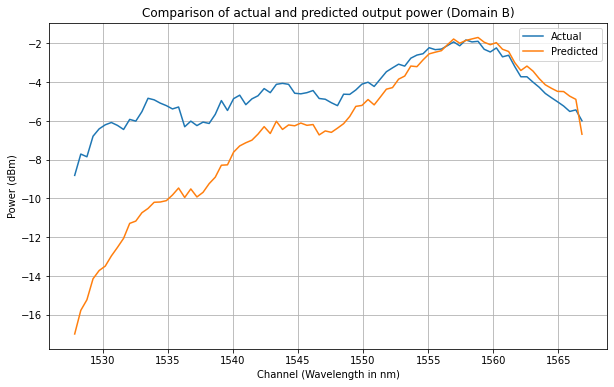

In [ ]:
# Get the input and output data for Domain A and B
X_A = domain_A.iloc[:, 3:87]
y_A = domain_A.iloc[:, 87:171]
X_B = domain_B.iloc[:, 3:87]
y_B = domain_B.iloc[:, 87:171]

# Split Domain A data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_A, y_A, test_size=0.2, random_state=42)

# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_A.shape[1]))
model.add(Dense(128, activation='relu'))
model.add(Dense(y_A.shape[1]))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=False)

# Predict on Domain A (validation set)
y_val_pred = model.predict(X_val)

# Predict on Domain B (test set)
y_test_pred = model.predict(X_B)

# Compute metrics on Domain A
mae_A = mean_absolute_error(y_val, y_val_pred)
mse_A = mean_squared_error(y_val, y_val_pred)
r2_A = r2_score(y_val, y_val_pred)

# Compute metrics on Domain B
mae_B = mean_absolute_error(y_B, y_test_pred)
mse_B = mean_squared_error(y_B, y_test_pred)
r2_B = r2_score(y_B, y_test_pred)

# Print metrics
print(f"Domain A - MAE: {mae_A}, MSE: {mse_A}, R2 Score: {r2_A}")
print(f"Domain B - MAE: {mae_B}, MSE: {mse_B}, R2 Score: {r2_B}")

# Draw a sample graph of one row in the domain B between the actual output and predict output
random_index = np.random.choice(X_B.index)
actual_output = y_B.loc[random_index]
predicted_output = y_test_pred[X_B.index.get_loc(random_index)]


plt.figure(figsize=(10, 6))
plt.plot(channels, actual_output, label='Actual')
plt.plot(channels, predicted_output, label='Predicted')
plt.title('Comparison of actual and predicted output power (Domain B)')
plt.xlabel('Channel (Wavelength in nm)')
plt.ylabel('Power (dBm)')
plt.legend()

# Use grid
plt.grid(True)
plt.show()


Transfer Learning - MAE: 0.3745665827400572, MSE: 0.3593860441465238, R2 Score: 0.9359130964667483
Linear Regression - MAE: 0.2038137160484477, MSE: 0.08389225090961831, R2 Score: 0.9797071414228161
ANN - MAE: 0.3367690241504143, MSE: 0.24732428792448824, R2 Score: 0.9570064372667191


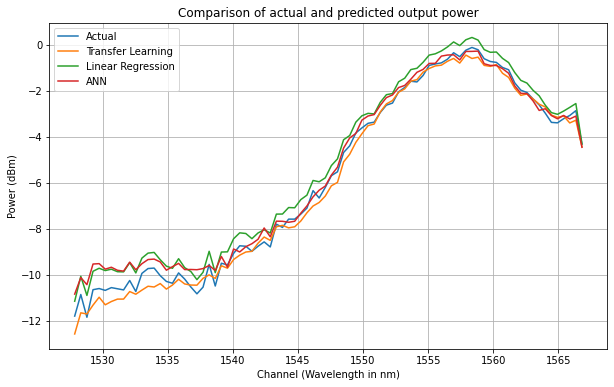

In [ ]:
# Prepare the training, validation, and test sets
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(X_B, y_B, test_size=0.2, random_state=42)

X_ann = pd.concat([X_A, X_B_train])
y_ann = pd.concat([y_A, y_B_train])

# Define the models
linear_model = LinearRegression()
ann_model = Sequential([Dense(128, activation='relu', input_dim=X_ann.shape[1]),
                        Dense(64, activation='relu'),
                        Dense(y_ann.shape[1])])
ann_model.compile(optimizer='adam', loss='mse')

# Train the models
linear_model.fit(X_ann, y_ann)
ann_history = ann_model.fit(X_ann, y_ann, epochs=50, verbose=False)

# Compute the metrics
models = [model, linear_model, ann_model]
names = ['Transfer Learning', 'Linear Regression', 'ANN']
for model, name in zip(models, names):
    y_pred = model.predict(X_B_test)
    mae = mean_absolute_error(y_B_test, y_pred)
    mse = mean_squared_error(y_B_test, y_pred)
    r2 = r2_score(y_B_test, y_pred)
    print(f"{name} - MAE: {mae}, MSE: {mse}, R2 Score: {r2}")

# Draw a comparison graph
random_index = np.random.choice(X_B_test.index)
actual_output = y_B_test.loc[random_index]

plt.figure(figsize=(10, 6))
plt.plot(channels, actual_output, label='Actual')
for model, name in zip(models, names):
    predicted_output = model.predict(X_B_test.loc[[random_index]])[0]
    plt.plot(channels, predicted_output, label=name)
plt.title('Comparison of actual and predicted output power')
plt.xlabel('Channel (Wavelength in nm)')
plt.ylabel('Power (dBm)')
plt.legend()

# Use grid
plt.grid(True)

plt.show()
